In [ ]:
!pip install -q transformers
# !pip install mlconjug3

     |████████████████████████████████| 2.3MB 5.4MB/s 
     |████████████████████████████████| 901kB 32.1MB/s 
     |████████████████████████████████| 3.3MB 35.7MB/s 


In [ ]:
from transformers import pipeline
from transformers import BertTokenizer, TFBertModel

In [ ]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline

from collections import Counter

# import mlconjug3
import numpy as np
import json

import matplotlib
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

In [ ]:
# nlp_fill = pipeline('fill-mask',model="neuralmind/bert-base-portuguese-cased", use_fast=True, top_k=10)
# # nlp_fill("Eu vou [MASK] uma palavra")


In [ ]:
def process(sentences, nlp_fill, verbose = True):
  results_1 = []
  results_2 = []
  corret1 = []
  corret2 = []  
  for sent, ans in sentences: 
    ans1, ans2 = ans.split()
    #trail 1
    s1 = sent.replace("[MASK2]", ans2)
    s1 = s1.replace("[MASK1]", "[MASK]")
    candidates = nlp_fill(s1)
    corret = False
    results_scores1 = []
    results_scores2 = []
    for cand in candidates:
      results_scores1.append((cand["token_str"], cand["score"]))
      if cand["token_str"].lower() == ans1:
        corret = True
      if verbose:
        print("\t", cand["token_str"], cand["score"], "correct:",cand["token_str"].lower() == ans1)
    corret1.append(1 if corret else 0)
    #trail 2
    s2 = sent.replace("[MASK1]", ans1)
    s2 = s2.replace("[MASK2]", "[MASK]")
    candidates = nlp_fill(s2)
    corret = False
    for cand in candidates:
      results_scores2.append((cand["token_str"], cand["score"]))
      if cand["token_str"].lower() == ans2:
        corret = True
      if verbose:
        print("\t", cand["token_str"], cand["score"], "correct:",cand["token_str"].lower() == ans2)
    corret2.append(1 if corret else 0)
    results_1.append(results_scores1)
    results_2.append(results_scores2)
  return (corret1, corret2), (results_1, results_2)



In [ ]:
def evaluate(candidates1, candidates2, sentences):
  all_p1 = []
  all_p2 = []
  for cands1, cands2, sent in zip(candidates1, candidates2, sentences):
    ans1 = sent[1].split()[0]
    ans2 = sent[1].split()[1]
    p1 = [] #P@K
    p2 = [] #P@K
    for c1, c2 in zip(cands1, cands2):
      correct = 1 if c1[0].lower() == ans1 else 0
      acc = max(correct, p1[-1]) if len(p1)>0 else correct
      p1.append(acc)

      correct = 1 if c2[0].lower() == ans2 else 0
      acc = max(correct, p2[-1]) if len(p2)>0 else correct
      p2.append(acc)
    all_p1.append(p1)
    all_p2.append(p2)
  ap1 = np.mean(all_p1,axis=0) #AP@K
  ap2 = np.mean(all_p2,axis=0) #AP@K
  return ap1, ap2
    

In [ ]:
def plot_results(x_labels,y_labels, x, title):
  fig, ax = plt.subplots(figsize=(20, 15))
  im = ax.imshow(x)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(x_labels)))
  ax.set_yticks(np.arange(len(y_labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(x_labels)
  ax.set_yticklabels(y_labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
  cbar = ax.figure.colorbar(im, ax=ax, cmap="Wistia")
  cbar.ax.set_ylabel("", rotation=-90, va="bottom")
  # Loop over data dimensions and create text annotations.
  for i in range(len(y_labels)):
      for j in range(len(x_labels)):
          text = ax.text(j, i, x[i][j],
                        ha="center", va="center", color="w")

  ax.set_title(title)
  # fig.tight_layout()
  plt.show()

In [ ]:
def __similarity_profile(mat1, mat2):
  sims = []
  for v1, v2 in zip(mat1, mat2):
    sim = 1-cosine(v1, v2)
    sims.append(sim)
  return sum(sims)/len(sims), sims

def __target_index(encoded_sent,ans1,ans2):
  r1 = -1
  r2 = -1
  for index, w in enumerate(encoded_sent):
    if w == ans1:
      r1 = index
    elif w == ans2:
      r2 = index
  return r1, r2


def __candidate_profile1(cand,sent,index,sentences,mat1,ans1,ans2):
  tks2 = tokenizer(sent[0].replace("[MASK1]",cand[0]).replace("[MASK2]",ans2))
  tks2 = tokenizer.decode(tks2['input_ids'])
  # print(tks2)
  mat2 = nlp_encoder([sent[0].replace("[MASK1]",cand[0]).replace("[MASK2]",ans2)])[0]
  # print("mat2",len(mat2), len(mat2[0]))
  avg_sim, sim_lst = __similarity_profile(mat1,mat2)
  # print("\t",cand[0], sim_lst[index1], avg_sim, sim_lst)

  target_sim_lst = []
  for sent in sentences:
    tks2 = tokenizer(sent[0].replace("[MASK1]",cand[0]).replace("[MASK2]",ans2))
    tks2 = tokenizer.decode(tks2['input_ids'])
    index1, index2 = __target_index(tks2,ans1,ans2)
    # print(tks2)
    mat2 = nlp_encoder([sent[0].replace("[MASK1]",cand[0]).replace("[MASK2]",ans2)])[0]
    # print("mat2",len(mat2), len(mat2[0]))
    _, sim_lst2 = __similarity_profile([mat1[index]],[mat2[index1]])
    target_sim_lst.append(sim_lst2[0])

  return sim_lst[index], avg_sim, sim_lst,target_sim_lst


def __candidate_profile2(cand,sent,index,sentences,mat1,ans1,ans2):
  tks2 = tokenizer(sent[0].replace("[MASK2]",cand[0]).replace("[MASK1]",ans1))
  tks2 = tokenizer.decode(tks2['input_ids'])
  # print(tks2)
  mat2 = nlp_encoder([sent[0].replace("[MASK2]",cand[0]).replace("[MASK1]",ans1)])[0]
  # print("mat2",len(mat2), len(mat2[0]))
  avg_sim, sim_lst = __similarity_profile(mat1,mat2)
  # print("\t",cand[0], sim_lst[index1], avg_sim, sim_lst)

  target_sim_lst = []
  for sent in sentences:
    tks2 = tokenizer(sent[0].replace("[MASK2]",cand[0]).replace("[MASK1]",ans1))
    tks2 = tokenizer.decode(tks2['input_ids'])
    index1, index2 = __target_index(tks2,ans1,ans2)
    # print(tks2)
    mat2 = nlp_encoder([sent[0].replace("[MASK2]",cand[0]).replace("[MASK1]",ans1)])[0]
    # print("mat2",len(mat2), len(mat2[0]))
    _, sim_lst2 = __similarity_profile([mat1[index]],[mat2[index2]])
    target_sim_lst.append(sim_lst2[0])

  return sim_lst[index], avg_sim, sim_lst,target_sim_lst

def similarity(candidates1, candidates2, sentences):
  all_p1 = []
  all_p2 = []
  for sent_index, (cands1, cands2, sent) in enumerate(zip(candidates1, candidates2, sentences)):
    ans1 = sent[1].split()[0]
    ans2 = sent[1].split()[1]
    print(sent_index, sent[1])
    tks = tokenizer(sent[0].replace("[MASK1]",ans1).replace("[MASK2]",ans2))
    tks = tokenizer.decode(tks['input_ids'])
    index1, index2 = __target_index(tks,ans1,ans2)
    # print(tks)
    mat1 = nlp_encoder([sent[0].replace("[MASK1]",ans1).replace("[MASK2]",ans2)])[0]
    # print("mat1",len(mat1), len(mat1[0]))
    # print("------")
    for c1, c2 in zip(cands1, cands2):
      target_sim, avg_sim, sim_lst,target_sim_lst = __candidate_profile1(c1,sent,index1,sentences,mat1,ans1,ans2)
      avg_sim_with_other_sents = (sum(target_sim_lst)-target_sim_lst[sent_index])/(len(target_sim_lst)-1)
      print("\tW1",c1[0], target_sim, avg_sim, avg_sim_with_other_sents, "\t-\t",target_sim_lst)

      target_sim, avg_sim, sim_lst,target_sim_lst = __candidate_profile2(c2,sent,index2,sentences,mat1,ans1,ans2)
      avg_sim_with_other_sents = (sum(target_sim_lst)-target_sim_lst[sent_index])/(len(target_sim_lst)-1)
      print("\tW2",c2[0], target_sim, avg_sim, avg_sim_with_other_sents, "\t-\t",target_sim_lst)
      


In [ ]:
# similarity(cand1, cand2, sentences)

#templates

In [ ]:
TASKS = {}

##gatos pingados

In [ ]:
TASKS["gatos pingados"] = [("Essa transferência reflete a desproporção entre a militância gay, influente nos meios culturais, e um ativismo negro que de ativismo só tem, até agora, o nome e o entusiasmo de uns [MASK1] [MASK2].","gatos pingados"),
                            ("Quando Cristo morreu no alto da cruz, além de Maria e do discípulo mais amado, havia quando muito uns trinta [MASK1] [MASK2] em volta.","gatos pingados"),
                            ("Essas nem fazem jus ao que o Kid Abelha prova ser nesta reunião de [MASK1] [MASK2] que deixara desmamados por aí:","gatos pingados"),
                            ("Vão prender meia dúzia de [MASK1] [MASK2], de QI pequeno, anões intelectuais.","gatos pingados"),
                            ("Entre aqueles [MASK1] [MASK2], que dez dias antes não se conheciam, que dentro de dez dias iriam se separar para sempre, que deveriam pensar apenas nos afetos e nos interesses que tinham deixado na Europa ou que os esperavam na América, lá, sobre aquelas quatro tábuas suspensas no abismo, já havia se urdido uma trama intrincada de antipatias e inimizades.","gatos pingados")]



##pé quente

In [ ]:
TASKS["pé quente"] = [("Não sei se sou [MASK1] [MASK2], porém, sei que em quase todas as cidades a que fui o resultado eleitoral foi positivo para o PT.", "pé quente"),
                        ("Mas o Armarinhos Fernando está mostrando que é [MASK1] [MASK2].", "pé quente"),
                        ("\"Me convidaram porque sou [MASK1] [MASK2]\", disse Helô.", "pé quente"),
                        ("Campeã em 91 e 92 pela Recra e em 93 e 95 pelo Leite Moça, a atleta diz ser \"[MASK1] [MASK2]\".", "pé quente"),
                        ("Josiane - Todo mundo diz que sou [MASK1] [MASK2], me tratam como se eu fosse o pé de coelho.", "pé quente")] 






##pé direito

In [ ]:
TASKS["pé direito"] = [("Todas as construções medem 3,2 0 de [MASK1] [MASK2], proporcionando ampla ventilação, tendo em vista a característica de clima quente da região.", "pé direito"),
                      ("i) Ter [MASK1] [MASK2] mínimo de 2,50m (dois metros e cinqüenta centímetros) j) Estar situada em local de fácil e seguro acesso, não sendo permitido um deslocamento superior à 150m (cento e cinqüenta metros).", "pé direito"),
                      ("Foram utilizados 2.112 pintos da marca comercial Ross, machos, alojados em galpão de alvenaria, com [MASK1] [MASK2] de 3,0 m, cobertura com telhas de cimento amianto, provido de lanternim, mureta com laterais de 0,50 m, tela de ½\".", "pé direito"),
                      ("Utilizou-se casa de vegetação tipo arco, coberto com filme de polietileno de baixa densidade, transparente de 100 micra de espessura com as dimensões de 7,0x30,0m, apresentando um [MASK1] [MASK2] de 3,0m.", "pé direito"),
                      ('Para isso, os alunos multiplicaram a área do piso (7,8 m2) pela altura do [MASK1] [MASK2] (2 m), chegando a 15,6 m3.', "pé direito")]


##pão duro

In [ ]:
TASKS["pão duro"] = [("Se você tem um pai [MASK1] [MASK2], não tenha dúvidas – peça a URV na sua mesada.","pão duro"),
                      ("Ele é um turco muito [MASK1] [MASK2].","pão duro"),
                      ("Trabalhador e [MASK1] [MASK2] assim o português é visto pelos brasileiros, considerando sua maior qualidade e seu maior defeito Das frutas do País a mais louvada É o régio Ananás, fruta tão boa.","pão duro"),
                      ("Só que o governo [MASK1] [MASK2] começa festejando a posse com uma festinha íntima.","pão duro"),
                      ("Ganhando mais espaço e agora bem mais descolado, porém nem tão pouco [MASK1] [MASK2], o rapaz virou comerciante, e através da sociedade com Sandy e Junior, inaugurou o Detonação, que acabou se tornando o verdadeiro Point da galera.","pão duro")]



##elefante branco

In [ ]:
TASKS["elefante branco"] = [("Exatamente por isso continuamos a nossa luta e hoje temos a satisfação de informar que teremos a conclusão da obra no final do ano em curso, o mais tardar no início do ano que vem , uma obra gigantesca, que poderia ter-se tornado um grande [MASK1] [MASK2] -- quase 50 % da obra pronta e cinco anos de paralisação, em completo abandono, o mato tomando conta.", "elefante branco"),
                              ("Os fundos de privatização do investimento que supervionam a maioria dos [MASK1] [MASK2] assumiram encargos financeiros, mas a falência eventual de alguns deles não seria menos desestabilizante que o colapso de um banco.", "elefantes brancos"),
                              ("O governo paulista deu nesta semana o pontapé inicial para tentar se livrar de um \"[MASK1] [MASK2]\", como o mercado imobiliário apelidou a estrutura de concreto na esquina da marginal Pinheiros com a avenida Juscelino Kubitschek (zona sul de São Paulo), onde ficaria a sede central da Eletropaulo (empresa de energia do Estado).", "elefante branco"),
                              ("Os ventos neoliberalizantes de Margareth Tacher na Inglaterra e de Ronald Reagan, nos EUA, chegam ao Brasil no final da década, com a eleição de Collor e com a campanha de que a máquina estatal era \"um [MASK1] [MASK2]\" que não funciona, como justificativa para a privatização de estatais, para a desregulamentação de setores estratégicos e para a redução da responsabilidade do Estado frente as questões sociais.", "elefante branco"),
                              ("Realmente, em um país sem trabalho, seus tribunais tornam-se [MASK1] [MASK2]...", "elefantes brancos")]






##pé frio

In [ ]:
TASKS["pé frio"] = [("Fui chamado de [MASK1] [MASK2]\") e , também estimulado pelo filho, voltou às partidas no Mineirão.", "pé frio"),
                      ("Eles terão pela frente o desafio de desmitificar a imagem de \"[MASK1] [MASK2]\" que o ponto ganhou.", "pé frio"),
                      ("Se o apoio de Clinton confirmar o [MASK1] [MASK2] da eleição israelense e Ieltsin perder, o risco de uma disputa regional insuflada pela indústria militar russa não será desprezível.", "pé frio"),
                      ("Sobre o [MASK1] [MASK2] da Pepsi, de que se falou na coluna de quarta, um atento leitor escreve para lembrar que, na Copa em que Zico perdeu o pênalti, o galinho era o garoto-propaganda do refrigerante.", "pé frio"),
                      ("Ainda assim, foi chamado de \"[MASK1] [MASK2]\" depois de perder duas Copas do Mundo, e, 1982 e 1986.", "pé frio")]


##olho gordo

In [ ]:
TASKS["olho gordo"] = [("É hora de olho aberto, para evitar o \"[MASK1] [MASK2]\" em cima do Mercosul.", "olho gordo"),
                        ("Não é de estranhar que todos estejam de [MASK1] [MASK2] no faturamento da PETROBRÁS:", "olho gordo"),
                        ("A estupenda tese de doutorado de Marcos Cezar de Freitas mostra como baixou [MASK1] [MASK2] violento, tanto na USP quanto no Cebrap (Centro Brasileiro de Análise e Planejamento), em cima do Instituto Superior de Estudos Brasileiros, localizado no Rio de Janeiro, inclusive ciúmes intelectuais.", "olho gordo"),
                        ("Os \"donos do mundo\" estão de [MASK1] [MASK2] na Amazônia.", "olho gordo"),
                        ("Quem olhar apenas a rentabilidade, de [MASK1] [MASK2] em ganhos rápidos e polpudos, pode se dar mal.", "olho gordo")]



##roleta russa

In [ ]:
TASKS["roleta russa"] = [("Nela, o autor avisava que um amigo dele, Nino, havia sido morto por ter matado outro rapaz, Edson Aparecido Manoel, no último dia 28, numa brincadeira de [MASK1] [MASK2].", "roleta russa"),
                          ("Assim, para quem não se conforma com o tédio do circuito comercial, é chegada a hora mágica de se submeter à \"[MASK1] [MASK2]\" da mostra.", "roleta russa"),
                          ("Por exemplo ele esta montando uma [MASK1] [MASK2], aquilo que eu falei pra você tem um a Rua do Arouche três horas da manha, é por que geralmente, eu moro ali do lado, eu moro no Largo do Arouche, três horas da manhã, ou só tem michê fazendo o ponto ou tem o pessoal passando, não é o tipo ideal de pessoa para um relacionamento.", "roleta russa"),
                          ("Aterrorizava suas vítimas fazendo [MASK1] [MASK2].", "roleta russa"),
                          ("Os autores do livro \"O Revólver que sempre dispara\" comparam o uso das primeiras doses de bebida alcóolica ou o uso de alguma outra droga, como a mesma coisa que entrar numa [MASK1] [MASK2].", "roleta russa")]


##montanha russa

In [ ]:
TASKS["montanha russa"] = [("Regina Cajazeira, com muita satisfação, na qualidade de viúva do compositor Lindembergue Cardoso e detentora de todos os originais dos seus manuscritos, o uso de parte do método complementar de Educação Musical de sua autoria, em que utiliza o parque de diversões como inspiração, mais especificamente Sombrinha, Roda Gigante, [MASK1] [MASK2], Tobogâ e Escorregadeira, para inclusão no Curso Batuta - Educação à Distância para Músicos de Filarmônica, com o objetivo exclusivo de pesquisa, que será defendida como tese de doutorado, no curso de pós-graduação da Universidade Federal da Bahia.", "montanha russa"),
                            ("Melancólicas na medida e espertas no uso da [MASK1] [MASK2] tecnológica, que é ordem do dia, suas canções _maioria no show, ainda bem_ padecem da crueza de palco do Blur.", "montanha russa"),
                            ("Em horários diferentes, eles subiram no brinquedo Space Mountain, [MASK1] [MASK2] que circula no escuro.", "montanha russa"),
                            ("Desde amarrar a pobre Penélope nos trilhos de uma [MASK1] [MASK2] até amarrá-la numa mina abandonada prestes a explodir, Tião Gavião tenta a todo custo acabar com nossa heroína.", "montanha russa"),
                            ("Esta região é a terra da [MASK1] [MASK2] de madeira, a Montezum, uma das atrações mais procuradas pelos visitantes.", "montanha russa")]


##olho mágico

In [ ]:
TASKS["olho mágico"] = [("Procuro imaginar aquele homem escanhoado e em mangas de camisa, desconto a deformação do [MASK1] [MASK2], e é sempre alguém conhecido mas muito difícil de reconhecer.", "olho mágico"),
                          ("Através do [MASK1] [MASK2] ao contrário, me vê como se eu fosse um homem côncavo.", "olho mágico"),
                          ("É claro que, em vez de instalar uma câmera de vídeo na porta, você poderia colocar um [MASK1] [MASK2] ou um bloco para recados.", "olho mágico"),
                          ("Não suspeitará que o vejo parar à minha porta, corrigindo a postura diante do [MASK1] [MASK2], e terá unha imunda o grosso polegar que aperta campainhas.", "olho mágico"),
                          ("Webcams vão ser instaladas em diversos pontos do condomínio, inclusive com a opção de [MASK1] [MASK2].", "olho mágico")]


##pau mandado

In [ ]:
TASKS["pau mandado"] = [("Não sou [MASK1] [MASK2] de ninguém.", "pau mandado"),
                          ("\"O governador tem interesse em eleger alguém passivo, um [MASK1] [MASK2] que não conteste suas ações\", disse.", "pau mandado"),
                          ("Estou absolutamente certo da vitória da nossa grande Luiza Holyfield sobre o [MASK1] [MASK2] do cara-de-Paulo, sim, do negro mais alma branca que eu já vi, o Celso PitTyson.", "pau mandado"),
                          ("Ele achou que eu seria empregado dele, um [MASK1] [MASK2].", "pau mandado"),
                          ("Em alguns lugares, tendo os europeus substituído por um [MASK1] [MASK2] o soba ou chefe legítimo, este continuou a receber clandestinamente a obediência de seus súditos e a sacrificar aos seus deuses e ancestrais.", "pau mandado")]

##sangue azul

In [ ]:
TASKS["sangue azul"] = [("E foi sumindo à medida que Falabella passou a ocupar o centro de gravidade do programa, até reduzir os demais atores, não obstante seus talentos específicos, a coadjuvantes, quando não a simples escadas para os grandes solos de Narciso do loiro de [MASK1] [MASK2], cuja diversão predileta é manifestar sua alergia crônica pela ralé.", "sangue azul"),
                            ("A granfina Prefere um rapaz de [MASK1] [MASK2] ou pelo menos azulado.", "sangue azul"),
                            ("Ao contrário de seu grande rival Voltaire, que também não tinha o [MASK1] [MASK2], não gostava de tal ambiente.", "sangue azul"),
                            ("Monarca, porque a única coisa que Fernando Henrique sabe fazer bem, sabe fazer como um verdadeiro [MASK1] [MASK2], é manifestar o seu desprezo pelo populacho, claro, e também o desprezo pela burguesia, sempre tão limitada e sem verniz.", "sangue azul"),
                            ("A família Alves, aqui é representada como \"dinastia sem coroa\" e \"sem [MASK1] [MASK2]\" ou \"família real Montesclarense\".", "sangue azul")]


##saia justa

In [ ]:
TASKS["saia justa"] = [("Foi numa dessas avaliações, em um grupo na Bahia, colocar em discussão a situação, naquela tremenda \"[MASK1] [MASK2]\".", "saia justa"),
                            ("Se você já foi pego de surpresa com tal pergunta na aula de História, este livro pode ajudá-lo a sair dessa [MASK1] [MASK2].", "saia justa"),
                            ("Segundo a joalheira Nícia Alves, 42, a postura a ser adotada para evitar uma [MASK1] [MASK2] é impor barreiras em uma situação como essa.", "saia justa"),
                            ("Protagonista de uma [MASK1] [MASK2] com Nizan Guanaes na campanha de 94 _com direito a cadeiradas, em briga apartada por Fernando Henrique Cardoso_, está de volta a Brasília o bruxo espanhol Carlos Pedregal.", "saia justa"),
                            ("A passagem de Paulo Tarso Flecha de Lima pelas comemorações pré-Copa em Los Gatos rendeu ao embaixador uma bela [MASK1] [MASK2].", "saia justa")]



##bode expiatório

In [ ]:
TASKS["bode expiatório"] = [("O líder dos perueiros disse que, por causa das declarações, foi transformado em \"[MASK1] [MASK2]\" da política de combate aos perueiros.", "bode expiatório"),
                              ("Seria a AIDS não mais que um evento político que se produziu pelo viés da saúde, que tem no vírus um [MASK1] [MASK2] poderoso?", "bode expiatório"),
                              ("O prefeito foi o herdeiro de muita coisa que está acontecendo hoje e não convém fazer dele um [MASK1] [MASK2], esquecendo dos outros que têm responsabilidade direta nisso.", "bode expiatório"),
                              ("A administração do Presidente Fernando Henrique Cardoso, que elegeu os servidores públicos como [MASK1] [MASK2] do ajuste salarial, arrochando seus salários durante seis anos, após pressões , ameaças de greve, insatisfações na caserna, ameaça de paralisação das atividades dos juízes, anuncia que está estudando essa possibilidade.", "bode expiatório"),
                              ("A inquietude foi reforçada com a desgraça de Thomas Osborne, primeiro duque de Leeds, que serviu de [MASK1] [MASK2] em um escândalo de corrupção com a França, pela compra, mediante suborno, da neutralidade política de Carlos II por parte de Luís XIV da França.", "bode expiatório")]





##ovelha negra

In [ ]:
TASKS["ovelha negra"] = [("Sensível e iconoclasta como seu tio Georg, fora considerado [MASK1] [MASK2] pela família.", "ovelha negra"),
                          ("Júlio Monteiro é a \"[MASK1] [MASK2]\" da cidade e ambiciona liderar a estância termal, mas por causa das suas brincadeiras de mau gosto e por saber demais sobre a vida dos moradores da cidade, atrai a ira de todos e é expulso.", "ovelha negra"),
                          ("Na versão da série lançada no Brasil , Punhais da Escuridão pode ser considerado uma \"[MASK1] [MASK2]\", já que faz parte de um conjunto maior de livros, todos de autoria de Sharp, que nunca foram traduzidos, deixando Punhais fora de contexto.", "ovelha negra"),
                          ("Quando reclamava de dor, o chefe dizia que eu estava nervosa, que isso era falta de homem, que eu era uma [MASK1] [MASK2], que não servia para nada.", "ovelha negra"),
                          ("O curso me ajudou a implantar uma gestão participativa na área de recursos materiais, que era um pouco [MASK1] [MASK2] na empresa.", "ovelha negra")]


##pente fino

In [ ]:
TASKS["pente fino"] = [("\"Estas medidas nada mais são do que um [MASK1] [MASK2]\", disse Ciro.", "pente fino"),
                        ("Depois de passar por um [MASK1] [MASK2] no qual todo canto das malas é revistado, eles ainda podem ter de pagar as gorjetas, subornos ou gratificações para mais alguns funcionários ou soldados, que ameaçam revistar tudo de novo caso não recebam o seu.", "pente fino"),
                        ("Mas o homem, sério e correto, mandou que fizessem uma devassa em sua vida pública e privada, que passassem o [MASK1] [MASK2], a fim de que os resultados do inquérito ficassem como padrão de exemplo para o mais honrado dos revolucionários.", "pente fino"),
                        ("Mas é indispensável, ao menos instrutivo, passar um [MASK1] [MASK2] na arte brasileira para se verificarem as diversas referências que atuaram no impulso de modernização, sem necessidade de legitimações.", "pente fino"),
                        ("A Folha apurou que técnicos da Receita passaram um \"[MASK1] [MASK2]\" nas contas de Macedo referentes ao período de 1990 a 1995.", "pente fino")]


##vista grossa

In [ ]:
TASKS["vista grossa"] = [("Quando se trata de analisar a economia capitalista, passa rápido ou faz [MASK1] [MASK2].", "vista grossa"),
                            ("Esse órgão foi criado para atrair grupos empresariais nacionais e estrangeiros para a região, oferecendo-lhes facilidades amorais em créditos bancários, incentivos fiscais e [MASK1] [MASK2] aos abusos aviltantes nas relações trabalhistas.", "vista grossa"),
                            ("Por isso, os Estados Unidos, durante um bom tempo, fizeram [MASK1] [MASK2] para o nacionalismo econômico, o que incluía políticas industriais seletivamente protecionistas e fortes incentivos às exportações.", "vista grossa"),
                            ("As companhias são unânimes em afirmar que fazem [MASK1] [MASK2] para os pequenos furtos.", "vista grossa"),
                            ("As grandes vivendas senhoriais, dotadas do maior conforto, mesa farta, pomares, parques e jardins atraem de tal modo a atenção do viajante, que este inadvertidamente (ou por puro hábito burguês) tende a fazer [MASK1] [MASK2] ao camponês que mora mal, mulher e filhos amontoados numa choupana com bichos domésticos, nas piores condições higiênicas imagináveis.", "vista grossa")]


##braço direito


In [ ]:
TASKS["braço direito"] = [("Graças à visita de Sig Bergamin, que carregou uma coleção direto das araras da Daslu, a moça - que mora em Paris, onde é [MASK1] [MASK2] de Valentino - arrematou tudo para estrelar toda tchans o verão da Sardenha.", "braço direito"),
                            ("Estes conflitos foram protagonizados não apenas pelo bispo D. Antônio, mas também pelo seu [MASK1] [MASK2], Monsenhor João Tolentino de Guedelha Mourão200, Vigário Geral da diocese, Diretor do Seminário Santo Antônio e um dos mais poderosos esteios do grupo ultramontano no Brasil201.", "braço direito"),
                            ("A execução da obra ficou sob a responsabilidade de Rudolfo Rehn, construtor licenciado e [MASK1] [MASK2] do arquiteto Willi Paul.", "braço direito"),
                            ("Esse gesto destemido de Tasso foi retribuído, não só num trabalho didático inovador na instituição, mas foi muito mais longe, como um entusiasta colaborador e um [MASK1] [MASK2] incansável na direção do Instituto.", "braço direito"),
                            ("É preciso assentar muito mais, mas o movimento dos sem-terra, [MASK1] [MASK2], ou melhor, braço esquerdo do Partido dos Trabalhadores, não respeita a propriedade produtiva.", "braço direito")]


##arma branca

In [ ]:
TASKS["arma branca"] = [("As principais causas de morte destes 31 trabalhadores foram homicídio (15 casos por arma de fogo e 3 com [MASK1] [MASK2]), seguido de acidentes de trânsito (5 colisões e 4 atropelamentos).", "arma branca"),
                          ("A diferença no volume de óbitos registrados com e sem a inclusão dos óbitos de intencionalidade desconhecida por [MASK1] [MASK2] e arma de fogo é menor do que para o Estado.", "arma branca"),
                          ("Os ferimentos por [MASK1] [MASK2] produzem maior incidência de tamponamento devido ao rápido fechamento do orifício produzido pelo objeto agressor e posterior acúmulo de líquido no saco pericárdico.", "arma branca"),
                          ("Por outro lado, nas cidades de mais de 100.000 habitantes, o número real de homicídios deve ser um valor intermediário entre aqueles medidos pelo SIM/MS e pela PMMG, ou seja, o SIM/MS pareceu recuperar de forma mais completa os óbitos por homicídios, embora possam ter sido incluídos indevidamente óbitos de homicídios cometidos em outros municípios menores e por [MASK1] [MASK2] e de fogo de intenção indeterminada que não tenham sido devidos a homicídios.", "arma branca"),
                          ("- Morreu de bala ou de [MASK1] [MASK2]?", "arma branca")] 


##sangue frio

In [ ]:
TASKS["sangue frio"] = [("Nada poderia torná-lo menos apto a conservar seu [MASK1] [MASK2] e a dar sua contribuição no decurso de um período de mudança social e intelectual rápido.", "sangue frio"),
                          ("Há curso por correspondência free-lance para a Folha Paciência, coragem, [MASK1] [MASK2] e equilíbrio redobrado.", "sangue frio"),
                          ("Apesar disso, dando mostras de [MASK1] [MASK2] notável, afirmou que a tripulação não corre perigo imediato.", "sangue frio"),
                          ("E que, a partir dele, nosso sistema de segurança pública seja melhorado, seja atualizado, tenha a estrutura necessária para prevenir e combater o crime, evitando que mais famílias chorem seus entes queridos, mortos a [MASK1] [MASK2] por bandidos que sabem que a insegurança é a sua melhor arma.", "sangue frio"),
                          ("Para Jacquet, a França precisa manter o [MASK1] [MASK2] para enfrentar as grandes armas da Croácia, segundo ele, o meio-campo técnico e a rapidez para chegar ao gol adversário.", "sangue frio")]


##primeira mão

In [ ]:
TASKS["primeira mão"] = [("Em [MASK1] [MASK2] – e com os votos de um retumbante final de ano – esta coluna adianta ao leitor quem vai ganhar o que do bom velhinho.", "primeira mão"),
                          ("Em várias oportunidades pude acompanhar dentro da corporação a repercussão de episódios que, na mesma manhã, havia tomado conhecimento através da imprensa ou, ao contrário, tomava conhecimento, em [MASK1] [MASK2], de fatos que se tornariam notícia no dia seguinte, mesmo que fossem episódios corriqueiros, cuja repercussão tenderia a se restringir apenas à unidade mais diretamente envolvida na situação.", "primeira mão"),
                          ("Presidente, trago uma notícia em [MASK1] [MASK2].", "primeira mão"),
                          ("A psicanálise ainda não nascida, coube então em [MASK1] [MASK2] à filosofia fazer um rastreamento desse sofrimento, na forma de várias teorias passionais locais:", "primeira mão"),
                          ("Desta forma, demonstramos em [MASK1] [MASK2], uma expressão apropriada para a magneto condutividade transversa devido ao confinamento bi-dimenisonal de elétrons em GaMnAs, sujeito a uma interação elétron-magnon trazida pela presença do íon Mn.", "primeira mão")] 


##cheiro verde

In [ ]:
TASKS["cheiro verde"] = [("\"Misture arroz, batata palha, ovo frito, [MASK1] [MASK2] e bacon numa tigela e sirva para todos\".", "cheiro verde"),
                          ("O consumo de 'caldo de feijão' (feijão liquidificado adicionado de bacon e [MASK1] [MASK2]), preparação típica de Lavras, foi similar entre alunos das escolas urbanas e rurais, apresentando alta freqüência (60%) para a citação do não consumo.", "cheiro verde"),
                          ("Quando ela começar a soltar do osso, jogue a mandioca, o [MASK1] [MASK2] e a cebola crua e cozinhe por mais dez minutos.", "cheiro verde"),
                          ("A hora de \"descer\" (tirar) a panela do fogo, coloca-se rodelas de cebola, cebolinha ([MASK1] [MASK2]) picada.", "cheiro verde"),
                          ("Misturado com alho, [MASK1] [MASK2] e sal, e batido, dá uma \"manteiga\" que muitos apreciam passada no pão, e outros como creme para diversas preparações salgadas.", "cheiro verde")] 


##pavio curto

In [ ]:
TASKS["pavio curto"] = [("Isso já é muita coisa para um jovem de [MASK1] [MASK2] bastante incapacitado pela fúria.", "pavio curto"),
                          ("Sou um pessoa de [MASK1] [MASK2] com a incompetência e a ausência de ações práticas.", "pavio curto"),
                          ("Ao contrário de sua pré-evolução, este pokémon tem [MASK1] [MASK2] e é conhecido por lançar chamas azuis e queimar o solo quando agitado.", "pavio curto"),
                          ("O consumidor, que deve estar de [MASK1] [MASK2] depois de tanta e impune indiferença quanto a seus direitos, vê agora tal pavio ficar tão queimado quanto as lâmpadas que a indústria tem colocado no mercado.", "pavio curto"),
                          ("Embora seu [MASK1] [MASK2] o metesse frequentemente em confusões, o jovem McIntosh começou a cantar e a tocar guitarra bem cedo, inspirado pelas estações americanas que ele conseguia sintonizar em seu rádio.", "pavio curto")] 


##livro aberto

In [ ]:
TASKS["livro aberto"] = [("Ou que gostaria que a sua vida ou a de alguém fosse um [MASK1] [MASK2]?", "livro aberto"),
                          ("Claro que Pelé tem quase 40 anos de vida pública e é o chamado [MASK1] [MASK2].", "livro aberto"),
                          ("Sobre o fato de estar sendo investigado pelo fisco, Marcelinho teria dito que sua vida \"é um [MASK1] [MASK2]\".", "livro aberto"),
                          ("Estes devem ter sua vida como um [MASK1] [MASK2].", "livro aberto"),
                          ("Sua vida é um [MASK1] [MASK2], que mostra a sua humildade autêntica e sua força extraordinária, que abalou os alicerces do então poderoso Império Britânico, que curvou-se a seus pés.", "livro aberto")]


##nó cego

In [ ]:
TASKS["nó cego"] = [("Um bom [MASK1] [MASK2] tem que ser ainda surdo e mudo.", "nó cego"),
                      ("Planejar um teste sem ter conhecimento bem claro disso é como realizar um [MASK1] [MASK2].", "nó cego"),
                      ("Só continuo tomando umas e distribuindo esses santinhos porque sou um tremendo [MASK1] [MASK2].", "nó cego"),
                      ("As relações sociais de sexo representavam o [MASK1] [MASK2] da psicodinâmica do trabalho.", "nó cego"),
                      ("Este [MASK1] [MASK2] ao qual nos remete o conceito de saúde da OMS, que hipotetizamos como articulado com a tendência de nossa sociedade, cada vez mais drogaticta, parece pôr em questão o nome comum (NEGRI, 2003b) \"saúde\", merecendo uma pesquisa mais aprofundada.", "nó cego")]


##pastor alemão

In [ ]:
TASKS["pastor alemão"] = [("São três cães, das raças rotweiller, dobermann e pastor alemão e mais seis filhotes, também da raça [MASK1] [MASK2].", "pastor alemão"),
                            ("Para as pessoas que simpatizam com o candidato do PSDB, Geraldo Alckmin seria uma pomba, inspirando suavidade e honestidade, um cordeiro, calmo e determinado, um [MASK1] [MASK2], confiável, obediente e fiel.", "pastor alemão"),
                            ("No último dia 5 , nove cachorros das raças dobermann e [MASK1] [MASK2] atacaram um menino de dois anos em uma fazenda em Quinta do Sol, na região de Maringá.", "pastor alemão"),
                            ("O técnico de laboratório Marivaldo Alves da Silva, 24, costuma levar Capitão, um [MASK1] [MASK2] de nove meses, à Dog Night.", "pastor alemão"),
                            ("E não estranhe se o [MASK1] [MASK2] do taxista ficar vigiando você.", "pastor alemão")] 

##alto falante

In [ ]:
TASKS["alto falante"] = [("Vou sair pela ruas gritando no [MASK1] [MASK2]:", "alto falante"),
                          ("Para instalação, aconselha-se um microcomputador 486, com 8 Mbytes de memória, placa de som, [MASK1] [MASK2] e toca-CD de dupla velocidade.", "alto falantes"),
                          ("Por conclamação do Prefeito, considerável massa popular aglomerou-se ontem à tarde em frente da prefeitura, onde tomava conhecimento de proclamações e medidas tomadas pela Câmara Municipal, transmitidas através de [MASK1] [MASK2] da rádio Carazinho, permanecendo a mesma Câmara, desde domingo, em sessão permanente.", "alto falante"),
                          ("12 é o número de [MASK1] [MASK2] que tem o Gol 95 do brasiliense Clayton Nunes Sampaio, 21, que passa o Carnaval em Porto Seguro.", "alto falantes"),
                          ("O arquivo de áudio será reproduzido pelo fone de ouvido ou pelo [MASK1] [MASK2], se o fone não estiver conectado.", "alto falante"),] 

##sangue quente

In [ ]:
TASKS["sangue quente"] = [("Os parisienses são carinhosos e o italianos têm o [MASK1] [MASK2].", "sangue quente"),
                            ("Ao deixar na geladeira o craque de [MASK1] [MASK2], Zagallo mostrou mais uma vez que é mais raposa do que propriamente lobo.", "sangue quente"),
                            ("Experiências traumáticas, especialmente padrões de apego tipo D (desorientado/insegur), poderão lesar o desenvolvimento de núcleos simpáticos no hipotálamo ventromedial e parassimpáticos no hipotálamo lateral, cruciais para uma posterior propensão à violência, tanto a de \"[MASK1] [MASK2]\", reativa, impulsiva, típica borderline, de tônus autonômico simpático, quanto a de \"sangue frio\", não-reativa, de busca de correção de estados de hipoativação, sociopática, bradicárdica, de tônus parassimpático.", "sangue quente"),
                            ("Depois de ser entrevistado por Lília Amarante para o \"Metrópolis\", Paco de Lucia mostrou que tem [MASK1] [MASK2].", "sangue quente"),
                            ("Por fim, espero que com serenidade possamos analisar as proposições do Governo, sem o [MASK1] [MASK2] das eleições municipais, pois votos se ganham nas ruas, nas praças e não na tribuna desta Casa.", "sangue quente")] 


##planta baixa

In [ ]:
TASKS["planta baixa"] = [("Os autos do processo contêm o termo de comodato e a [MASK1] [MASK2] em que se localizam as diversas dependências:", "planta baixa"),
                          ("Nesta coleção de gravuras foram encontrados desenhos relativos aos Engenhos Jaguarari e Mocajuba, inclusive, a [MASK1] [MASK2] deste último, que não foi ainda publicada integralmente.", "planta baixa"),
                          ("Caso a solicitação contenha equipamentos fixos (com ênfase para os ambientes de lavanderia, Central de Material Esterilizado e radiologia), é necessária a apresentação de [MASK1] [MASK2] para a análise técnica referente à arquitetura.", "planta baixa"),
                          ("Se por um lado, naquele momento, nossas expectativas de encontrar outras evidências arqueológicas foram frustradas e muitos questionamentos surgiram, por outro lado, pouco tempo depois foi localizada, no AHRGS, a [MASK1] [MASK2] deste posto, surgindo assim uma possível explicação para a ausência de prédios distintos para guarda e coletoria.", "planta baixa"),
                          ("1) Na [MASK1] [MASK2], identifica-se cada atividade listada na carta de processo, no local em que ela acontece.", "planta baixa"),] 


##longa metragem

In [ ]:
TASKS["longa metragem"] = [("Poderão beneficiar-se de abatimento de setenta por cento do imposto devido, a pessoa física ou jurídica residente ou domiciliada no exterior que invista no desenvolvimento de projetos de produção de obras cinematográficas brasileiras de [MASK1] [MASK2], na co-produção de telefilmes e minisséries brasileiros e de obras cinematográficas brasileiras, de produção independente, em projetos previamente aprovados pela Agência Nacional do Cinema (Ancine).", "longa metragem"),
                              ("O jovem e desconhecido na época Andrei Tarkovski emocionou platéias e a crítica internacional com seu primeiro [MASK1] [MASK2] \"A Infância de Ivan\".", "longa metragem"),
                              ("Estão rodando, segundo me informam, 200 filmes de [MASK1] [MASK2], e o que hoje está difícil no mercado são atores, técnicos e todo o pessoal necessário a uma indústria que tão bem conjuga mão-de-obra e inteligência.", "longa metragem"),
                              ("Invasão de Privacidade (Sliver) é um [MASK1] [MASK2] norte-americano de 1993.", "longa metragem"),
                              ("Dirigida por Miguel Milano e Antonio Leite, o [MASK1] [MASK2] \"Os Faroleiros\" tem roteiro inspirado no conto homônimo (de \"Urupês\") de Monteiro Lobato que, inclusive, assessora a adaptação.", "longa metragem")] 

##caixa preta

In [ ]:
TASKS["caixa preta"] = [("A prefeitura é uma [MASK1] [MASK2].", "caixa preta"),
                          ("Com esse instrumentos , vamos abrir a [MASK1] [MASK2] dos latifúndios, disse o ministro Raul Jungmann (Política Fundiária), um dos autores da proposta do novo ITR.", "caixa preta"),
                          ("A escola cretarias de Educação admitem, como critério para acesso à função continua vista como uma [MASK1] [MASK2];", "caixa preta"),
                          ("Nesse sentido, pode-se dizer que vários foram aqueles que beberam dessas águas, buscando desvendar a \"[MASK1] [MASK2]\" coasiana.", "caixa preta"),
                          ("Da mesma forma, a abertura da [MASK1] [MASK2] da prefeitura municipal durante o processo de discussão do orçamento foi um momento ímpar para que as lideranças comunitárias e a população em geral pudessem entender o funcionamento da máquina administrativa, decifrar o significado do orçamento, conhecer as fontes de recursos disponíveis e a natureza das despesas da prefeitura.", "caixa preta")] 


##peso morto

In [ ]:
TASKS["peso morto"] = [("A massa de analfabetos, [MASK1] [MASK2] para o progresso da nação, constitui mácula que nos deve envergonhar.", "peso morto"),
                      ("Na análise da burocracia da UE, a pedido e cercada de cuidados, a Argentina caiu na própria armadilha da paridade do peso com o dólar, o Paraguai é um vulcão de crises políticas e o Uruguai é uma espécie de [MASK1] [MASK2].", "peso morto"),
                      ("Erguia-se da mesa \"empachada\", lerdo, sonolento, com a impressão de ter engolido um tijolo, - atirava-se na cama como um [MASK1] [MASK2] , para uma sesta longa de sono inquieto, do qual despertava com a boca amarga, a cabeça dolorida, irritado e infeliz.", "peso morto"),
                      ("Existe um [MASK1] [MASK2] que o governo carrega nas costas.", "peso morto"),
                      ("Do mesmo modo, Ildefonso Escobar, um antigo membro do Conselho Nacional de Geografia, via o índio como um [MASK1] [MASK2] para a nação.", "peso morto")]


##quinta categoria

In [ ]:
TASKS["quinta categoria"] = [("O ato é um show de boate de [MASK1] [MASK2] (ri).", "quinta categoria"),
                              ("Mas minha futurologia é de [MASK1] [MASK2], e (nesse ponto Stone e Tarantino estão de acordo) talvez assim se esteja prestando a melhor homenagem ao momento atual.", "quinta categoria"),
                              ("Segundo a reportagem, o programa é \"uma mistura de música, crítica social barata, propagandas de [MASK1] [MASK2], troca de sopapos entre convidados e um desfile de aberrações que compõem um verdadeiro freak show\".", "quinta categoria"),
                              ("Nessa constelação de setores peso-pesados da economia, a experiência de outra câmara ligada à cultura, a do livro, virou uma estrela de [MASK1] [MASK2] e nunca apresentou nenhum resultado.", "quinta categoria"),
                              ("Em Brasília, os jornais de hoje exibem textos jornalísticos que ovacionam a fanfarronice verborrágica de inspirados vocalistas de grupos musicais de [MASK1] [MASK2] que se destacaram num festival que teve o nome besta de Brasília Music Festival - talvez até acertado, pois um Festival de Música em Brasília poderia ser inapropriado para o amontoado de besteiras publicadas nos jornais.", "quinta categoria")] 

#test

##bert-base-portuguese-cased

In [ ]:
nlp_fill = pipeline('fill-mask',model="neuralmind/bert-base-portuguese-cased", use_fast=True, top_k=10)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
nlp_encoder = pipeline('feature-extraction', model="neuralmind/bert-base-portuguese-cased", tokenizer=tokenizer)


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


... gatos pingados
gatos pingados 1.0 0.0
	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... pé quente
pé quente 0.4 0.8
	 [0.  0.  0.  0.2 0.2 0.2 0.2 0.4 0.4 0.4]
	 [0.2 0.4 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.8]
... pé direito
pé direito 1.0 1.0
	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
... pão duro
pão duro 0.0 0.2
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	 [0.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
... elefante branco
elefante branco 0.0 1.0
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
... pé frio
pé frio 0.6 0.8
	 [0.  0.4 0.4 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
	 [0.2 0.2 0.2 0.2 0.2 0.4 0.6 0.8 0.8 0.8]
... olho gordo
olho gordo 0.8 0.0
	 [0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
... roleta russa
roleta russa 0.0 1.0
	 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
... montanha russa
montanha russa 0.6 0.8
	 [0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]
	 [0.6 0.6 0.6 0.6 0.6 0.6 0

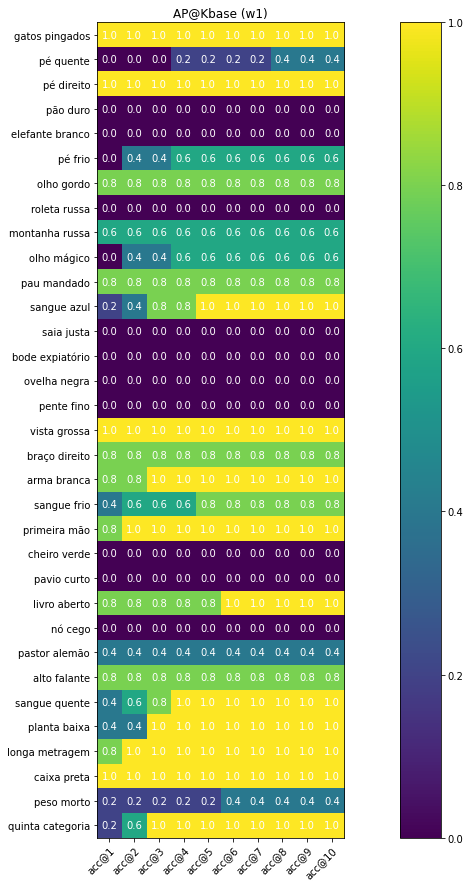

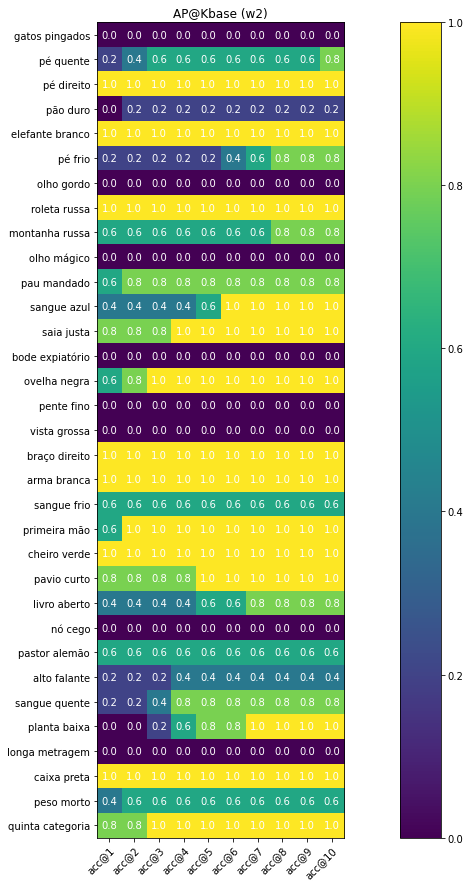

CPU times: user 1min 15s, sys: 792 ms, total: 1min 16s
Wall time: 1min 16s


In [ ]:
%%time
results_pos_compressed = {}
results_ood_compressed = {}
map1 = []
map2 = []

similarity_test_lst = []
for task in TASKS:
  print("...",task)
  sentences = TASKS[task]
  (acc1, acc2), (cand1, cand2) = process(sentences, nlp_fill, verbose = False)
  acc1 = sum(acc1)/len(sentences)
  acc2 = sum(acc2)/len(sentences)
  print(task, acc1, acc2)
  accAt_1, accAt_2 = evaluate(cand1, cand2, sentences)
  map1.append(accAt_1)
  map2.append(accAt_2)
  print("\t", accAt_1)
  print("\t", accAt_2)
  similarity_test_lst.append((cand1, cand2, sentences))

print("MAP@K")
print(np.mean(map1,axis=0))
print(np.mean(map2,axis=0))

plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map1[0]))],y_labels = list(TASKS.keys()), x=map1, title="AP@K"+"base (w1)")
plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map2[0]))],y_labels = list(TASKS.keys()), x=map2, title="AP@K"+"base (w2)")


In [ ]:
for cand1, cand2, sentences in similarity_test_lst:
  similarity(cand1, cand2, sentences)

0 gatos pingados
	W1 gatos 1.0 1.0 0.5559992282367223 	-	 [1.0, 0.4425513779964607, 0.5911860031277676, 0.6969921523463438, 0.4932673794763167]
	W2 brancos 0.2511910585398309 0.9446483898050502 0.5535814172908535 	-	 [0.9962000239897963, 0.41065766896609157, 0.5904484780055649, 0.7273741950781201, 0.4858453271136377]
	W1 dois 0.9967735844596253 0.9705863104905703 0.5439620536731712 	-	 [0.9967735844596253, 0.40468416917297156, 0.5921000834757446, 0.690972879589035, 0.48809108245493316]
	W2 gatos 0.2528135166509472 0.9475939443098278 0.5497598904871 	-	 [0.9973565978327612, 0.4164506109982111, 0.5960030153214311, 0.7121947743445612, 0.474391161284197]
	W1 pés 0.9988399155352736 0.9790033983344205 0.5485527082035708 	-	 [0.9988399155352736, 0.40899385165151125, 0.5874812119313644, 0.702472789847711, 0.4952629793836967]
	W2 negros 0.2262766408200424 0.9369433788340443 0.5552845582507306 	-	 [0.9890524754939171, 0.39748920619239536, 0.6035277420960138, 0.7421316043996506, 0.477989680314863

##bert-large-portuguese-cased

In [ ]:
nlp_fill = pipeline('fill-mask',model="neuralmind/bert-large-portuguese-cased", use_fast=True, top_k=10)

In [ ]:
%%time
results_pos_compressed = {}
results_ood_compressed = {}
map1 = []
map2 = []
similarity_test_lst = []
for task in TASKS:
  print("...",task)
  sentences = TASKS[task]
  (acc1, acc2), (cand1, cand2) = process(sentences, nlp_fill, verbose = False)
  acc1 = sum(acc1)/len(sentences)
  acc2 = sum(acc2)/len(sentences)
  print(task, acc1, acc2)
  accAt_1, accAt_2 = evaluate(cand1, cand2, sentences)
  map1.append(accAt_1)
  map2.append(accAt_2)
  print("\t", accAt_1)
  print("\t", accAt_2)
  similarity_test_lst.append((cand1, cand2, sentences))

print("MAP@K")
print(np.mean(map1,axis=0))
print(np.mean(map2,axis=0))

plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map1[0]))],y_labels = list(TASKS.keys()), x=map1, title="AP@K"+"large (w1)")
plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map2[0]))],y_labels = list(TASKS.keys()), x=map2, title="AP@K"+"large (w2)")


In [ ]:
for cand1, cand2, sentences in similarity_test_lst:
  similarity(cand1, cand2, sentences)

0 gatos pingados
	W1 gatos 1.0 1.0 0.5559992282367223 	-	 [1.0, 0.4425513779964607, 0.5911860031277676, 0.6969921523463438, 0.4932673794763167]
	W2 brancos 0.2511910585398309 0.9446483898050502 0.5535814172908535 	-	 [0.9962000239897963, 0.41065766896609157, 0.5904484780055649, 0.7273741950781201, 0.4858453271136377]
	W1 olhos 0.9984078784803835 0.9747811777985308 0.5472274973235035 	-	 [0.9984078784803835, 0.401671398030477, 0.5825754552839799, 0.7160598760517615, 0.48860325992779585]
	W2 negros 0.2262766408200424 0.9369433788340443 0.5552845582507306 	-	 [0.9890524754939171, 0.39748920619239536, 0.6035277420960138, 0.7421316043996506, 0.47798968031486333]
	W1 ouvidos 0.9978629412708183 0.977287842678255 0.5469304879114121 	-	 [0.9978629412708183, 0.40685864109801817, 0.5998866848537656, 0.7011244606995509, 0.47985216499431327]
	W2 gatos 0.2528135166509472 0.9475939443098278 0.5497598904871 	-	 [0.9973565978327612, 0.4164506109982111, 0.5960030153214311, 0.7121947743445612, 0.47439116

##mBERT

In [ ]:
nlp_fill = pipeline('fill-mask',model="bert-base-multilingual-cased", use_fast=True, top_k=10)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
%%time
results_pos_compressed = {}
results_ood_compressed = {}
map1 = []
map2 = []
similarity_test_lst = []
for task in TASKS:
  print("...",task)
  sentences = TASKS[task]
  (acc1, acc2), (cand1, cand2) = process(sentences, nlp_fill, verbose = False)
  acc1 = sum(acc1)/len(sentences)
  acc2 = sum(acc2)/len(sentences)
  print(task, acc1, acc2)
  accAt_1, accAt_2 = evaluate(cand1, cand2, sentences)
  map1.append(accAt_1)
  map2.append(accAt_2)
  print("\t", accAt_1)
  print("\t", accAt_2)
  similarity_test_lst.append((cand1, cand2, sentences))

print("MAP@K")
print(np.mean(map1,axis=0))
print(np.mean(map2,axis=0))

plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map1[0]))],y_labels = list(TASKS.keys()), x=map1, title="AP@K"+"mBERT (w1)")
plot_results(x_labels = ["acc@"+str(v+1) for v in range(len(map2[0]))],y_labels = list(TASKS.keys()), x=map2, title="AP@K"+"mBERT (w2)")


In [ ]:
for cand1, cand2, sentences in similarity_test_lst:
  similarity(cand1, cand2, sentences)

0 gatos pingados
	W1 os 0.9978826239392311 0.9705999044237117 0.5399084436635672 	-	 [0.9978826239392311, 0.38727262460161005, 0.6011683779634653, 0.710849928998506, 0.46034284309068707]
	W2 negros 0.2262766408200424 0.9369433788340443 0.5552845582507306 	-	 [0.9890524754939171, 0.39748920619239536, 0.6035277420960138, 0.7421316043996506, 0.47798968031486333]
	W1 uns 0.9963258734918136 0.9751475524585561 0.5414398941325383 	-	 [0.9963258734918136, 0.3896586934417794, 0.6094873293481816, 0.6910945338262026, 0.4755190199139898]
	W2 gay 0.20329360163640653 0.9250903520225026 0.5615419912095012 	-	 [0.9787761430280408, 0.42860470873099055, 0.6076419062554138, 0.7172206527249535, 0.49270069712664744]
	W1 mais 0.9967412341291061 0.9666273947129419 0.5484421465836058 	-	 [0.9967412341291061, 0.4260695554456333, 0.5902118910676895, 0.7087715440397597, 0.4687155957813407]
	W2 negro 0.20650346026711408 0.9153619497627296 0.5539119674707109 	-	 [0.9809975769164776, 0.4038565993099392, 0.609745677